In [254]:
# importar paquetes a ocupar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gradio
import os

In [177]:
# importar archivos
crossBattlelog = pd.read_parquet('datasets/teams/battlelog_teams.parquet')
crossBattlelog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589695 entries, 0 to 589694
Data columns (total 44 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   battleTime                             589695 non-null  object 
 1   playertag                              589695 non-null  object 
 2   event_mode                             589695 non-null  object 
 3   event_map                              589695 non-null  object 
 4   battle_type                            589695 non-null  object 
 5   battle_result                          589695 non-null  object 
 6   battle_duration                        589695 non-null  float64
 7   battle_trophyChange                    438155 non-null  float64
 8   battle_team1_player1_tag               589695 non-null  object 
 9   battle_team1_player1_name              589691 non-null  object 
 10  battle_team1_player1_brawler_id        589695 non-null  

In [180]:
# leer brawler stats
brawlers = pd.read_parquet('datasets/brawlers/brawlers_stats.parquet')
brawlers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              64 non-null     int64  
 1   name            64 non-null     object 
 2   starPowers.0    64 non-null     object 
 3   starPowers.1    64 non-null     object 
 4   gadgets.0       64 non-null     object 
 5   gadgets.1       64 non-null     object 
 6   Brawler         64 non-null     object 
 7   Health          64 non-null     float64
 8   Rarity          64 non-null     object 
 9   Class           64 non-null     object 
 10  Movement_Speed  64 non-null     object 
 11  Range           63 non-null     object 
 12  Reload          63 non-null     object 
 13  Speed_Num       64 non-null     int64  
 14  Range_Num       64 non-null     float64
 15  Reload_Num      63 non-null     float64
 16  Role            64 non-null     object 
dtypes: float64(3), int64(2), object(12)
m

In [181]:
# leer datos de mapa
bushList = pd.read_csv('datasets/maps/bushList.csv', index_col=0)
bushList.columns = bushList.columns.str.replace('.', '_')
waterList = pd.read_csv('datasets/maps/waterList.csv', index_col=0)
waterList.columns = waterList.columns.str.replace('.', '_')
barrierList = pd.read_csv('datasets/maps/barrierList.csv', index_col=0)
barrierList.columns = barrierList.columns.str.replace('.', '_')

C:\Users\alniquia\AppData\Local\Temp\ipykernel_9296\3581368576.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  bushList.columns = bushList.columns.str.replace('.', '_')
C:\Users\alniquia\AppData\Local\Temp\ipykernel_9296\3581368576.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  waterList.columns = waterList.columns.str.replace('.', '_')
C:\Users\alniquia\AppData\Local\Temp\ipykernel_9296\3581368576.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  barrierList.columns = barrierList.columns.str.replace('.', '_')

In [182]:
# leer brawler winrate y userate
brawler_wr_ur = pd.read_csv('datasets/teams/brawler_winrate_userate.csv', index_col=0)
brawler_wr_ur.columns = brawler_wr_ur.columns.str.replace('.', '_')

C:\Users\alniquia\AppData\Local\Temp\ipykernel_9296\4239264556.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  brawler_wr_ur.columns = brawler_wr_ur.columns.str.replace('.', '_')


In [75]:
# función para identificar a que team pertenece el player
def team_assignment(row):
    if any(row['playertag'] == tag for tag in [row.battle_team1_player1_tag, row.battle_team1_player2_tag, row.battle_team1_player3_tag]):
        return 'team1'
    elif any(row['playertag'] == tag for tag in [row.battle_team2_player1_tag, row.battle_team2_player2_tag, row.battle_team2_player3_tag]):
        return 'team2'
    else:
        return "error in team assignation for id " + str(row.name)

crossBattlelog['player_team'] = crossBattlelog.apply(team_assignment, axis=1)

crossBattlelog['player_team'].value_counts()

team1    267222
team2    263986
Name: player_team, dtype: int64

In [76]:
# eliminar draws, no aportan al modelo
crossBattlelog = crossBattlelog[crossBattlelog['battle_result'] != 'draw'].reset_index(drop=True)

In [77]:
# crear columna winner_team
def winner_assignment(row):
    if (row.player_team == 'team1' and row.battle_result == 'victory') or (row.player_team == 'team2' and row.battle_result == 'defeat'):
        return 'team1'
    elif (row.player_team == 'team2' and row.battle_result == 'victory') or (row.player_team == 'team1' and row.battle_result == 'defeat'):
        return 'team2'
    else:
        return "error in winner assignation for id " + str(row.name)

crossBattlelog['winner_team'] = crossBattlelog.apply(winner_assignment, axis=1)

crossBattlelog['winner_team'].value_counts()

team1    267118
team2    260597
Name: winner_team, dtype: int64

In [78]:
#escoger columnas a ocupar
crossBattlelog = crossBattlelog[[	
	'event_mode'
	,'event_map'
	,'battle_type'
	,'battle_duration'
	,'battle_team1_player1_brawler_name'
	,'battle_team1_player1_brawler_power'
	,'battle_team1_player1_brawler_trophies'
	,'battle_team1_player2_brawler_name'
	,'battle_team1_player2_brawler_power'
	,'battle_team1_player2_brawler_trophies'
	,'battle_team1_player3_brawler_name'
	,'battle_team1_player3_brawler_power'
	,'battle_team1_player3_brawler_trophies'
	,'battle_team2_player1_brawler_name'
	,'battle_team2_player1_brawler_power'
	,'battle_team2_player1_brawler_trophies'
	,'battle_team2_player2_brawler_name'
	,'battle_team2_player2_brawler_power'
	,'battle_team2_player2_brawler_trophies'
	,'battle_team2_player3_brawler_name'
	,'battle_team2_player3_brawler_power'
	,'battle_team2_player3_brawler_trophies'
	,'player_team'
	,'winner_team'
]]

crossBattlelog.head()

,event_mode,event_map,battle_type,battle_duration,battle_team1_player1_brawler_name,battle_team1_player1_brawler_power,battle_team1_player1_brawler_trophies,battle_team1_player2_brawler_name,battle_team1_player2_brawler_power,battle_team1_player2_brawler_trophies,...,battle_team2_player1_brawler_power,battle_team2_player1_brawler_trophies,battle_team2_player2_brawler_name,battle_team2_player2_brawler_power,battle_team2_player2_brawler_trophies,battle_team2_player3_brawler_name,battle_team2_player3_brawler_power,battle_team2_player3_brawler_trophies,player_team,winner_team
0,brawlBall,Sunny Soccer,ranked,67.0,TARA,7.0,274.0,EL PRIMO,9.0,489.0,...,8.0,354.0,BULL,7.0,354.0,JACKY,8.0,350.0,team1,team1
1,hotZone,Dueling Beetles,soloRanked,118.0,MAX,10.0,13.0,BEA,11.0,13.0,...,11.0,14.0,STU,11.0,14.0,OTIS,11.0,12.0,team1,team1
2,hotZone,Dueling Beetles,soloRanked,125.0,MAX,10.0,13.0,BEA,11.0,13.0,...,11.0,14.0,STU,11.0,14.0,OTIS,11.0,12.0,team1,team2
3,hotZone,Dueling Beetles,soloRanked,143.0,MAX,10.0,13.0,BEA,11.0,13.0,...,11.0,14.0,STU,11.0,14.0,OTIS,11.0,12.0,team1,team1
4,heist,Bridge Too Far,soloRanked,71.0,MAX,11.0,14.0,PIPER,10.0,13.0,...,11.0,14.0,BEA,10.0,12.0,MEG,11.0,13.0,team2,team2


In [92]:
# crear columna winner
def subset_winner(df, team):

	df['winner'] = 'no'

	for i, winner_team in enumerate(df['winner_team']):
		if winner_team == team:
			df.loc[i, 'winner'] = 'yes'

	df = df.rename(columns={
		'battle_' + team + '_player1_brawler_name': 'battle_player1_brawler_name'
		,'battle_' + team + '_player1_brawler_power': 'battle_player1_brawler_power'
		,'battle_' + team + '_player1_brawler_trophies': 'battle_player1_brawler_trophies'
		,'battle_' + team + '_player2_brawler_name': 'battle_player2_brawler_name'
		,'battle_' + team + '_player2_brawler_power': 'battle_player2_brawler_power'
		,'battle_' + team + '_player2_brawler_trophies': 'battle_player2_brawler_trophies'
		,'battle_' + team + '_player3_brawler_name': 'battle_player3_brawler_name'
		,'battle_' + team + '_player3_brawler_power': 'battle_player3_brawler_power'
		,'battle_' + team + '_player3_brawler_trophies': 'battle_player3_brawler_trophies'
	})

	df = df[[	
		'event_mode'
		,'event_map'
		,'battle_type'
		,'battle_duration'
		,'battle_player1_brawler_name'
		,'battle_player1_brawler_power'
		,'battle_player1_brawler_trophies'
		,'battle_player2_brawler_name'
		,'battle_player2_brawler_power'
		,'battle_player2_brawler_trophies'
		,'battle_player3_brawler_name'
		,'battle_player3_brawler_power'
		,'battle_player3_brawler_trophies'
		,'winner'
	]]

	return df

def clean_winner(team):

	if team == 'team1':
		oteam = 'team2'
	else:
		oteam = 'team1'
	
	subset = crossBattlelog[crossBattlelog['winner_team'] == team].reset_index(drop=True)

	dfwinners = subset_winner(subset, team)

	dfloosers = subset_winner(subset, oteam)

	return pd.concat([dfwinners, dfloosers], ignore_index=True)

team1 = clean_winner('team1')
team2 = clean_winner('team2')

battlelogProcess = pd.concat([team1, team2], ignore_index=True)
battlelogProcess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1055430 entries, 0 to 1055429
Data columns (total 14 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   event_mode                       1055430 non-null  object 
 1   event_map                        1055430 non-null  object 
 2   battle_type                      1055430 non-null  object 
 3   battle_duration                  1055430 non-null  float64
 4   battle_player1_brawler_name      1055430 non-null  object 
 5   battle_player1_brawler_power     1055430 non-null  float64
 6   battle_player1_brawler_trophies  1055430 non-null  float64
 7   battle_player2_brawler_name      1055430 non-null  object 
 8   battle_player2_brawler_power     1055430 non-null  float64
 9   battle_player2_brawler_trophies  1055430 non-null  float64
 10  battle_player3_brawler_name      1055429 non-null  object 
 11  battle_player3_brawler_power     1055429 non-null 

In [93]:
battlelogProcess.head()

,event_mode,event_map,battle_type,battle_duration,battle_player1_brawler_name,battle_player1_brawler_power,battle_player1_brawler_trophies,battle_player2_brawler_name,battle_player2_brawler_power,battle_player2_brawler_trophies,battle_player3_brawler_name,battle_player3_brawler_power,battle_player3_brawler_trophies,winner
0,brawlBall,Sunny Soccer,ranked,67.0,TARA,7.0,274.0,EL PRIMO,9.0,489.0,MANDY,10.0,288.0,yes
1,hotZone,Dueling Beetles,soloRanked,118.0,MAX,10.0,13.0,BEA,11.0,13.0,LEON,11.0,13.0,yes
2,hotZone,Dueling Beetles,soloRanked,143.0,MAX,10.0,13.0,BEA,11.0,13.0,LEON,11.0,13.0,yes
3,heist,Bridge Too Far,soloRanked,50.0,COLT,10.0,14.0,JESSIE,11.0,12.0,EVE,11.0,12.0,yes
4,heist,Bridge Too Far,soloRanked,73.0,COLT,10.0,14.0,JESSIE,11.0,12.0,EVE,11.0,12.0,yes


In [95]:
# merge brawler stats
battlelogFinal = battlelogProcess

def add_brawlers(df, prefix):
	df = pd.merge(left=df, right=brawlers[['name','Health','Rarity','Class','Movement_Speed','Range','Reload','Speed_Num','Range_Num','Reload_Num','Role']].add_prefix(prefix), on=prefix + 'name', how='left', suffixes=('','_b'))
	return df

battlelogFinal = add_brawlers(battlelogFinal, 'battle_player1_brawler_')
battlelogFinal = add_brawlers(battlelogFinal, 'battle_player2_brawler_')
battlelogFinal = add_brawlers(battlelogFinal, 'battle_player3_brawler_')

battlelogFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1055430 entries, 0 to 1055429
Data columns (total 44 columns):
 #   Column                                 Non-Null Count    Dtype  
---  ------                                 --------------    -----  
 0   event_mode                             1055430 non-null  object 
 1   event_map                              1055430 non-null  object 
 2   battle_type                            1055430 non-null  object 
 3   battle_duration                        1055430 non-null  float64
 4   battle_player1_brawler_name            1055430 non-null  object 
 5   battle_player1_brawler_power           1055430 non-null  float64
 6   battle_player1_brawler_trophies        1055430 non-null  float64
 7   battle_player2_brawler_name            1055430 non-null  object 
 8   battle_player2_brawler_power           1055430 non-null  float64
 9   battle_player2_brawler_trophies        1055430 non-null  float64
 10  battle_player3_brawler_name            105

In [98]:
# merge map data
battlelogFinal = battlelogFinal.merge(barrierList, how='inner', on='event_map')
battlelogFinal = battlelogFinal.merge(bushList, how='inner', on='event_map')
battlelogFinal = battlelogFinal.merge(waterList, how='left', on='event_map')
battlelogFinal['waterProp'] = battlelogFinal['waterProp'].fillna(0)
battlelogFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1055430 entries, 0 to 1055429
Data columns (total 49 columns):
 #   Column                                 Non-Null Count    Dtype  
---  ------                                 --------------    -----  
 0   event_mode                             1055430 non-null  object 
 1   event_map                              1055430 non-null  object 
 2   battle_type                            1055430 non-null  object 
 3   battle_duration                        1055430 non-null  float64
 4   battle_player1_brawler_name            1055430 non-null  object 
 5   battle_player1_brawler_power           1055430 non-null  float64
 6   battle_player1_brawler_trophies        1055430 non-null  float64
 7   battle_player2_brawler_name            1055430 non-null  object 
 8   battle_player2_brawler_power           1055430 non-null  float64
 9   battle_player2_brawler_trophies        1055430 non-null  float64
 10  battle_player3_brawler_name            105

In [101]:
# merge winrate y userate
def add_wr_ur(df, prefix):
	df = pd.merge(
		left=df
		,right=brawler_wr_ur[['brawlername', 'event_mode', 'event_map', 'winrate', 'userate', 'percentile_quadrant']].add_prefix(prefix)
		,left_on=[prefix + 'name', 'event_mode', 'event_map']
		,right_on=[prefix + 'brawlername', prefix + 'event_mode', prefix + 'event_map']
		,how='left'
		,suffixes=('','_w'))
	return df

battlelogFinal = add_wr_ur(battlelogFinal, 'battle_player1_brawler_')
battlelogFinal = add_wr_ur(battlelogFinal, 'battle_player2_brawler_')
battlelogFinal = add_wr_ur(battlelogFinal, 'battle_player3_brawler_')

battlelogFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1055430 entries, 0 to 1055429
Data columns (total 67 columns):
 #   Column                                      Non-Null Count    Dtype  
---  ------                                      --------------    -----  
 0   event_mode                                  1055430 non-null  object 
 1   event_map                                   1055430 non-null  object 
 2   battle_type                                 1055430 non-null  object 
 3   battle_duration                             1055430 non-null  float64
 4   battle_player1_brawler_name                 1055430 non-null  object 
 5   battle_player1_brawler_power                1055430 non-null  float64
 6   battle_player1_brawler_trophies             1055430 non-null  float64
 7   battle_player2_brawler_name                 1055430 non-null  object 
 8   battle_player2_brawler_power                1055430 non-null  float64
 9   battle_player2_brawler_trophies             1055430 non-n

In [102]:
plt.style.use('ggplot')

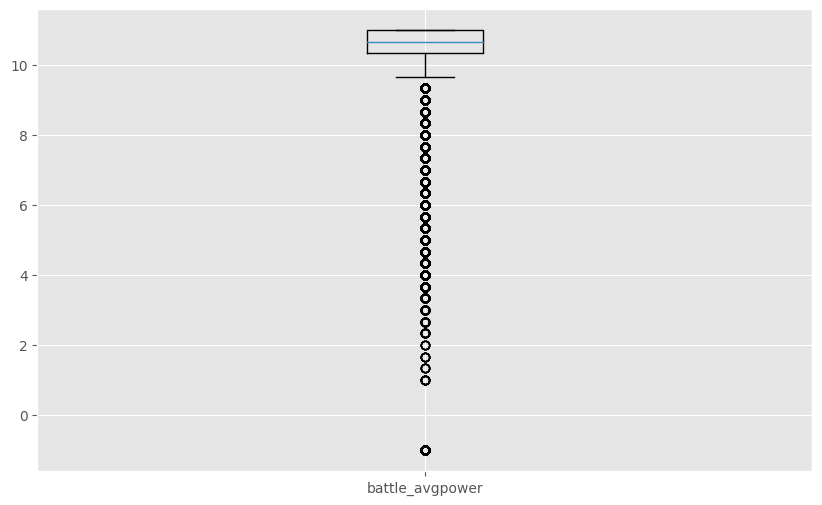

In [109]:
# crear columna avg power
def create_avg(row, column):
    return (row['battle_player1_brawler_'+ column] + row['battle_player2_brawler_'+ column] + row['battle_player3_brawler_'+ column]) / 3

def create_boxplots(df, col1):
    fig, ax = plt.subplots()
    fig.set_size_inches(6, 6)
    ax.boxplot(df[col1])
    ax.set_xticklabels([col1])
    plt.show()

battlelogFinal['battle_avgpower'] = battlelogFinal.apply(lambda row: create_avg(row, 'power'), axis=1)
battlelogFinal = battlelogFinal[battlelogFinal['battle_avgpower'].isna() == False]
battlelogFinal['battle_avgpower'] = battlelogFinal.apply(lambda row: create_avg(row, 'power'), axis=1)
battlelogFinal = battlelogFinal[battlelogFinal['battle_avgpower'].isna() == False]

create_boxplots(battlelogFinal, 'battle_avgpower')

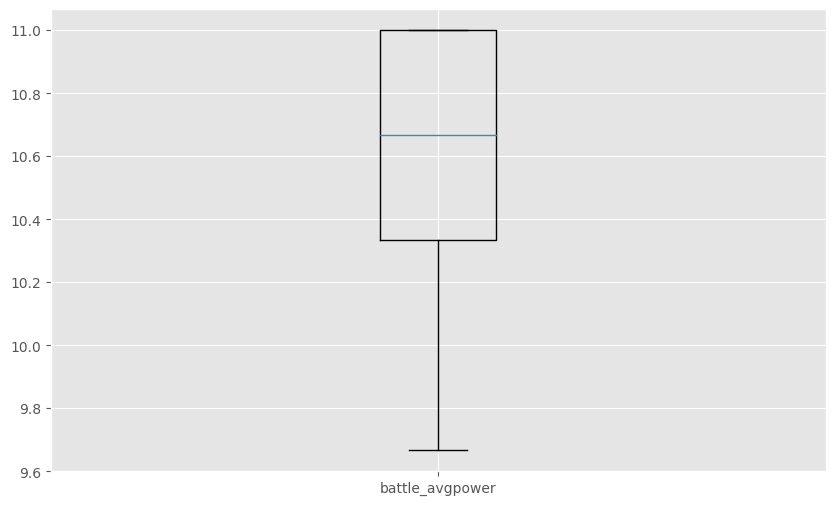

In [110]:
# subset avg power
battlelogFinal = battlelogFinal[battlelogFinal['battle_avgpower'] > 9.5].reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle_avgpower')

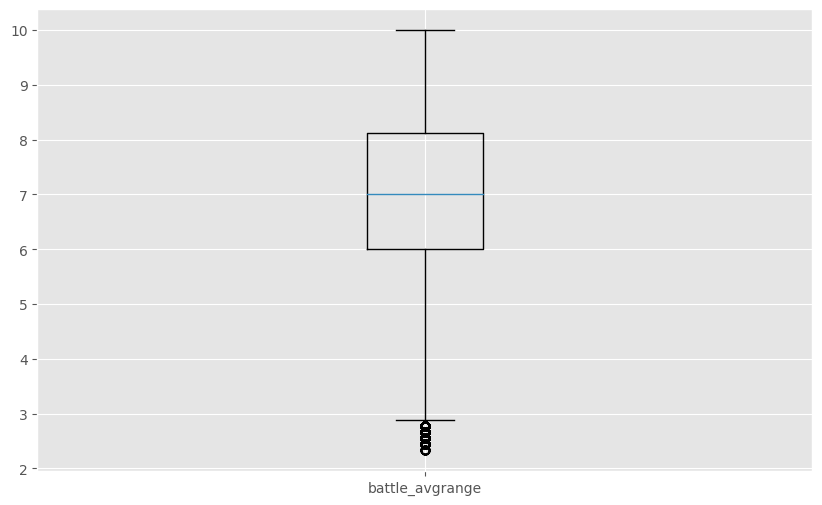

In [265]:
# crear columna avg range
battlelogFinal['battle_avgrange'] = battlelogFinal.apply(lambda row: create_avg(row, 'Range_Num'), axis=1)

create_boxplots(battlelogFinal, 'battle_avgrange')

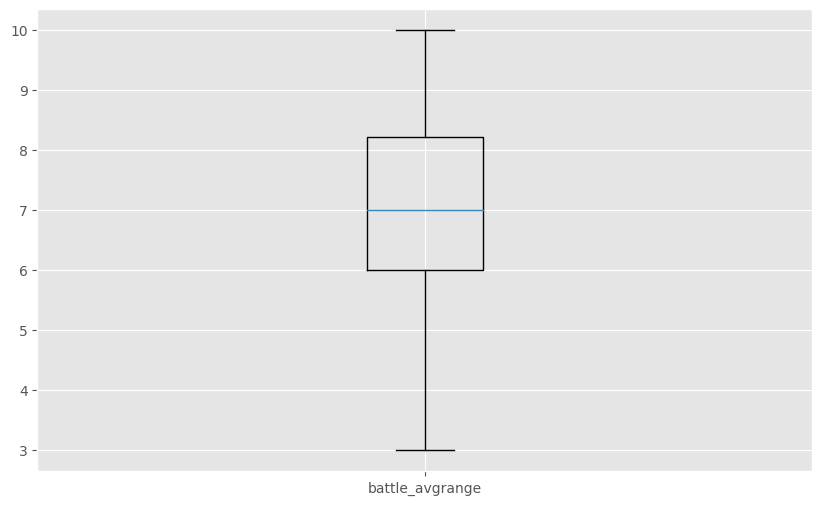

In [266]:
# subset avg range
battlelogFinal = battlelogFinal[battlelogFinal['battle_avgrange'] > 2.9].reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle_avgrange')

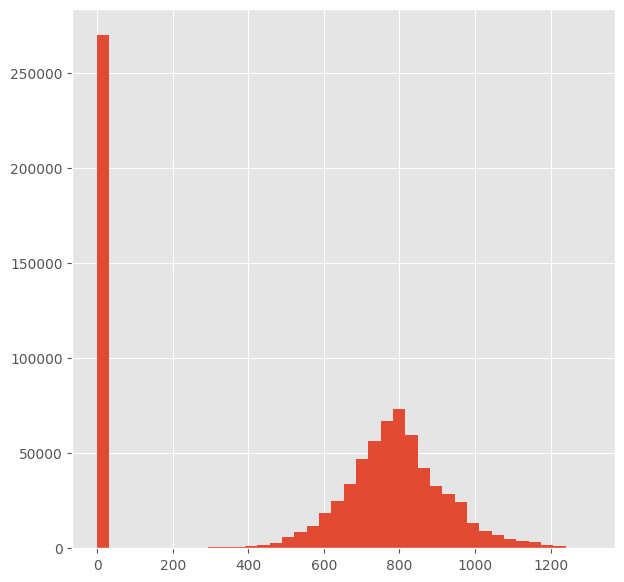

In [141]:
# crear columna avg trophies
battlelogFinal['battle_avgtrophies'] = battlelogFinal.apply(lambda row: create_avg(row, 'trophies'), axis=1)

fig, ax = plt.subplots(figsize=(7,7))
ax.hist(x=battlelogFinal['battle_avgtrophies'], bins=40)
plt.show()

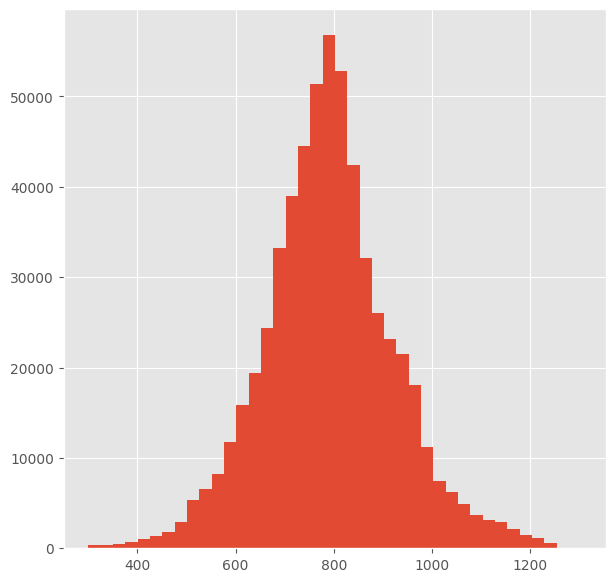

In [145]:
# subset avg trophies
battlelogFinal = battlelogFinal[battlelogFinal['battle_avgtrophies'] >= 300].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(7,7))
ax.hist(x=battlelogFinal['battle_avgtrophies'], bins=40)
plt.show()

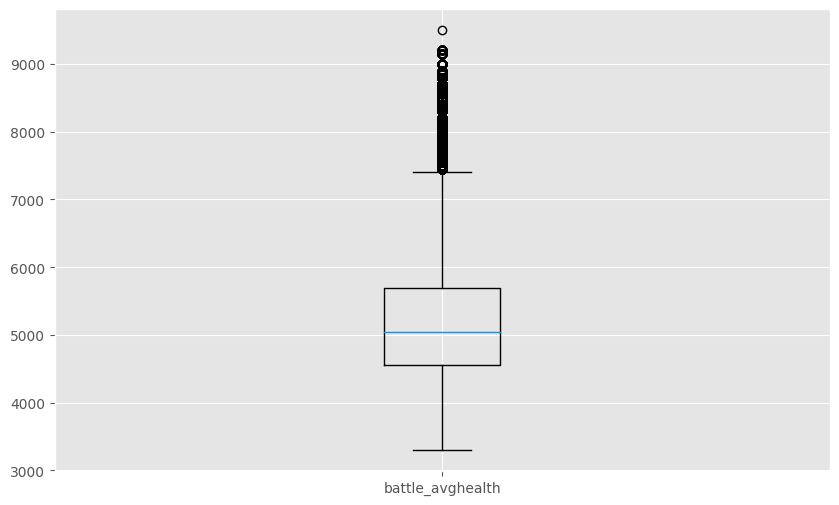

In [112]:
# crear columna avg health
battlelogFinal['battle_avghealth'] = battlelogFinal.apply(lambda row: create_avg(row, 'Health'), axis=1).reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle_avghealth')

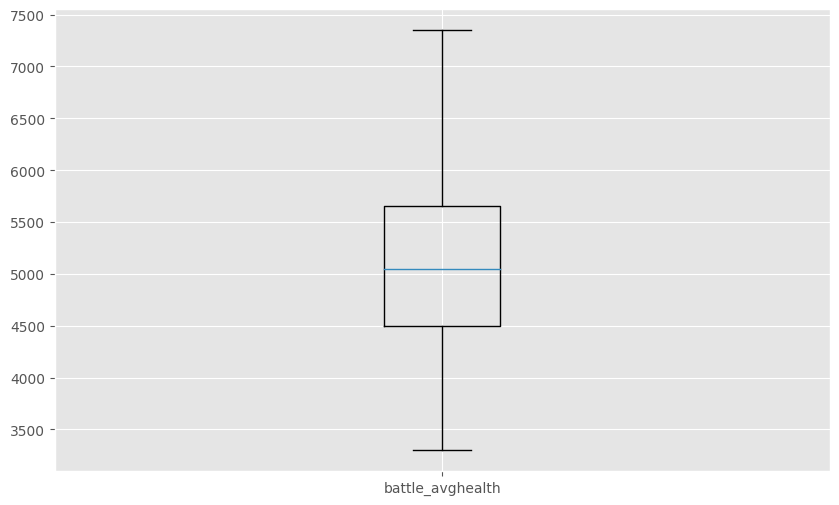

In [113]:
# subset avg health
battlelogFinal = battlelogFinal[battlelogFinal['battle_avghealth'] < 7400].reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle_avghealth')

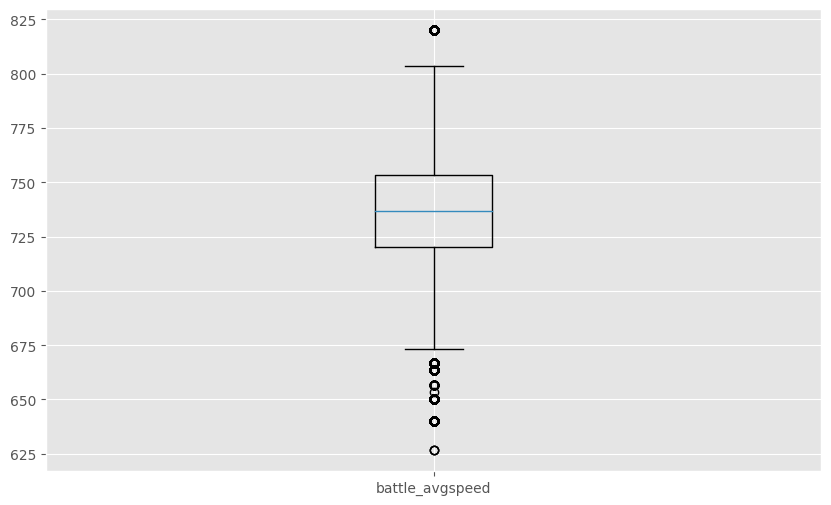

In [114]:
# crear columna avg speed
battlelogFinal['battle_avgspeed'] = battlelogFinal.apply(lambda row: create_avg(row, 'Speed_Num'), axis=1)

create_boxplots(battlelogFinal, 'battle_avgspeed')

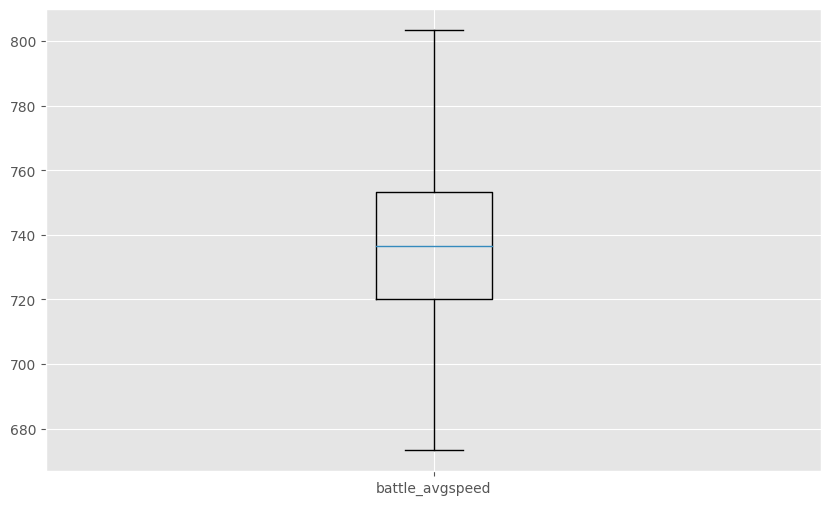

In [115]:
# subset avg speed
battlelogFinal = battlelogFinal[(battlelogFinal['battle_avgspeed'] >= 670) & (battlelogFinal['battle_avgspeed'] <= 810)].reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle_avgspeed')

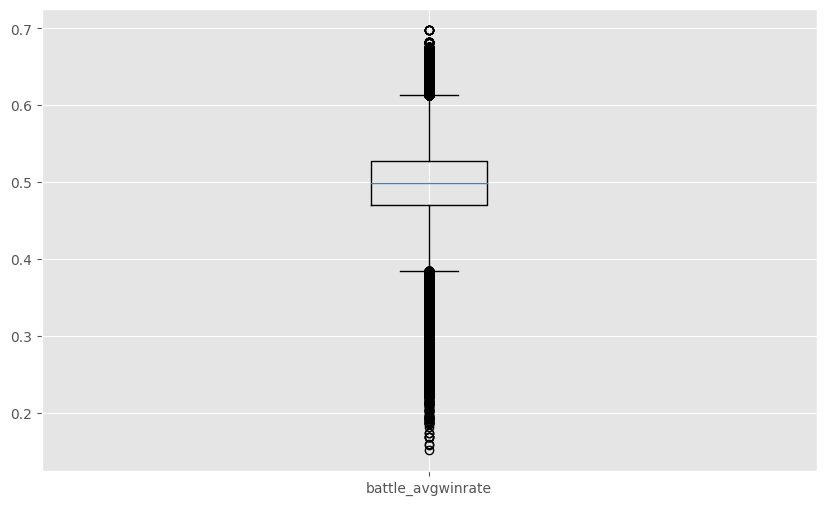

In [116]:
# crear columna avg winrate
battlelogFinal['battle_avgwinrate'] = battlelogFinal.apply(lambda row: create_avg(row, 'winrate'), axis=1)
battlelogFinal = battlelogFinal[battlelogFinal['battle_avgwinrate'].isna() == False]

create_boxplots(battlelogFinal, 'battle_avgwinrate')

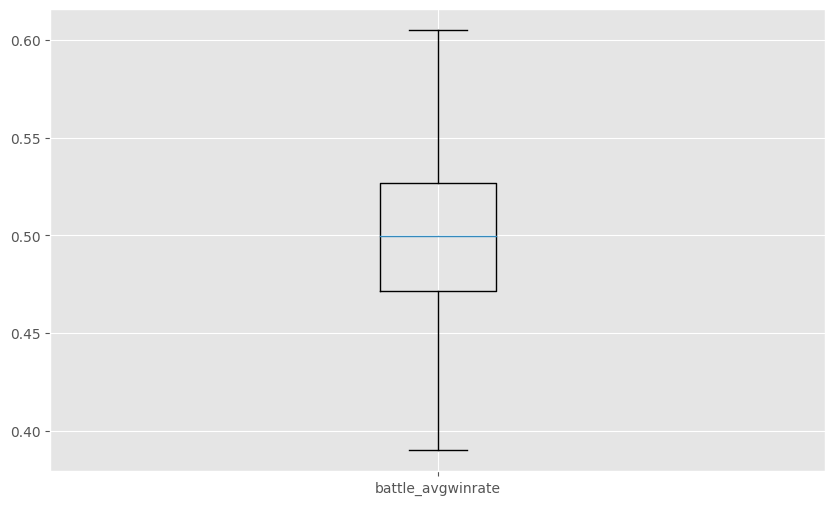

In [117]:
# subset avg winrate
battlelogFinal = battlelogFinal[(battlelogFinal['battle_avgwinrate'] >= 0.39) & (battlelogFinal['battle_avgwinrate'] <= 0.605)].reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle_avgwinrate')

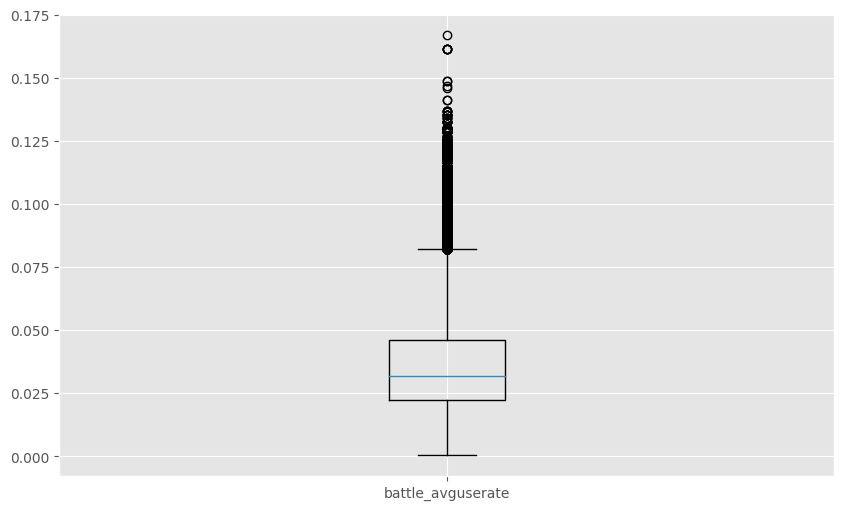

In [118]:
# crear columna avg userate
battlelogFinal['battle_avguserate'] = battlelogFinal.apply(lambda row: create_avg(row, 'userate'), axis=1)

create_boxplots(battlelogFinal, 'battle_avguserate')

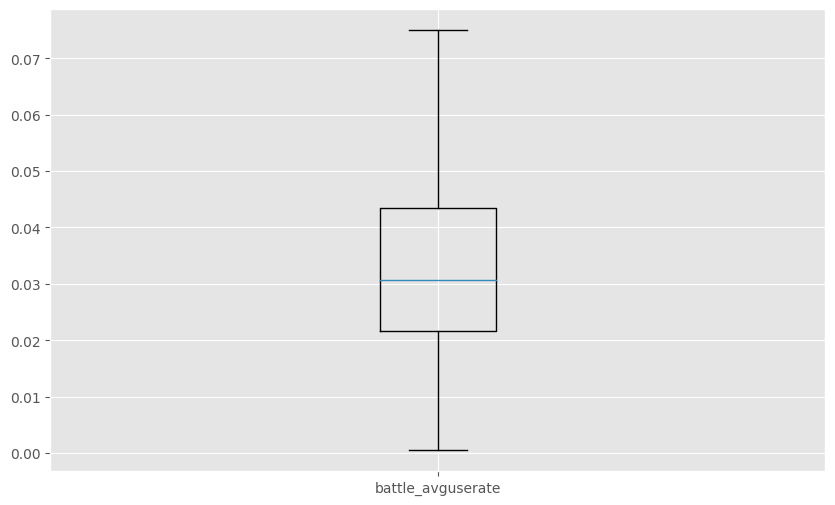

In [122]:
# subset avg userate
battlelogFinal = battlelogFinal[battlelogFinal['battle_avguserate'] <= 0.075].reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle_avguserate')

In [267]:
# best brawlers
def get_min_max_rest(row, column_names):
    a, b, c = row[column_names[0]], row[column_names[1]], row[column_names[2]]
    min_val = min(a, b, c)
    max_val = max(a, b, c)
    rest_val = (a + b + c) - min_val - max_val
    return min_val, max_val, rest_val

def order_rows(df, column):
	column_names = ['battle_player1_brawler_' + column, 'battle_player2_brawler_' + column, 'battle_player3_brawler_' + column]
	min_vals, max_vals, rest_vals = zip(*df.apply(lambda x: get_min_max_rest(x, column_names), axis=1))
	df['battle_' + column + '_min'] = min_vals
	df['battle_' + column + '_max'] = max_vals
	df['battle_' + column + '_med'] = rest_vals
	return df

In [268]:
battlelogFinal = order_rows(battlelogFinal, 'power')
battlelogFinal = order_rows(battlelogFinal, 'trophies')
battlelogFinal = order_rows(battlelogFinal, 'Health')
battlelogFinal = order_rows(battlelogFinal, 'Range_Num')
battlelogFinal = order_rows(battlelogFinal, 'Speed_Num')
battlelogFinal = order_rows(battlelogFinal, 'winrate')
battlelogFinal = order_rows(battlelogFinal, 'userate')

In [269]:
battlelogFinal.shape

(583339, 95)

In [270]:
# definición final de columnas
def subset_battlelog(gamemode):

	df = battlelogFinal[[
	'winner'
	,'battle_avgtrophies'
	,'battle_trophies_min'
	,'battle_trophies_max'
	,'battle_avgpower'
	,'battle_power_min'
	,'battle_power_max'
	,'battle_avgrange'
	,'battle_Range_Num_min'
	,'battle_Range_Num_max'
	,'battle_avghealth'
	,'battle_Health_min'
	,'battle_Health_max'
	,'battle_avgspeed'
	,'battle_Speed_Num_min'
	,'battle_Speed_Num_max'
	,'battle_avgwinrate'
	,'battle_winrate_min'
	,'battle_winrate_max'
	,'battle_avguserate'
	,'battle_userate_min'
	,'battle_userate_max'
	]][battlelogFinal['event_mode'] == gamemode].reset_index(drop=True)

	return df

def subset_complete():
	df = battlelogFinal[[
	'winner'
	,'battle_avgtrophies'
	,'battle_trophies_min'
	,'battle_trophies_max'
	,'battle_avgpower'
	,'battle_power_min'
	,'battle_power_max'
	,'battle_avgrange'
	,'battle_Range_Num_min'
	,'battle_Range_Num_max'
	,'battle_avghealth'
	,'battle_Health_min'
	,'battle_Health_max'
	,'battle_avgspeed'
	,'battle_Speed_Num_min'
	,'battle_Speed_Num_max'
	,'battle_avgwinrate'
	,'battle_winrate_min'
	,'battle_winrate_max'
	,'battle_avguserate'
	,'battle_userate_min'
	,'battle_userate_max'
	]].reset_index(drop=True)

	return df

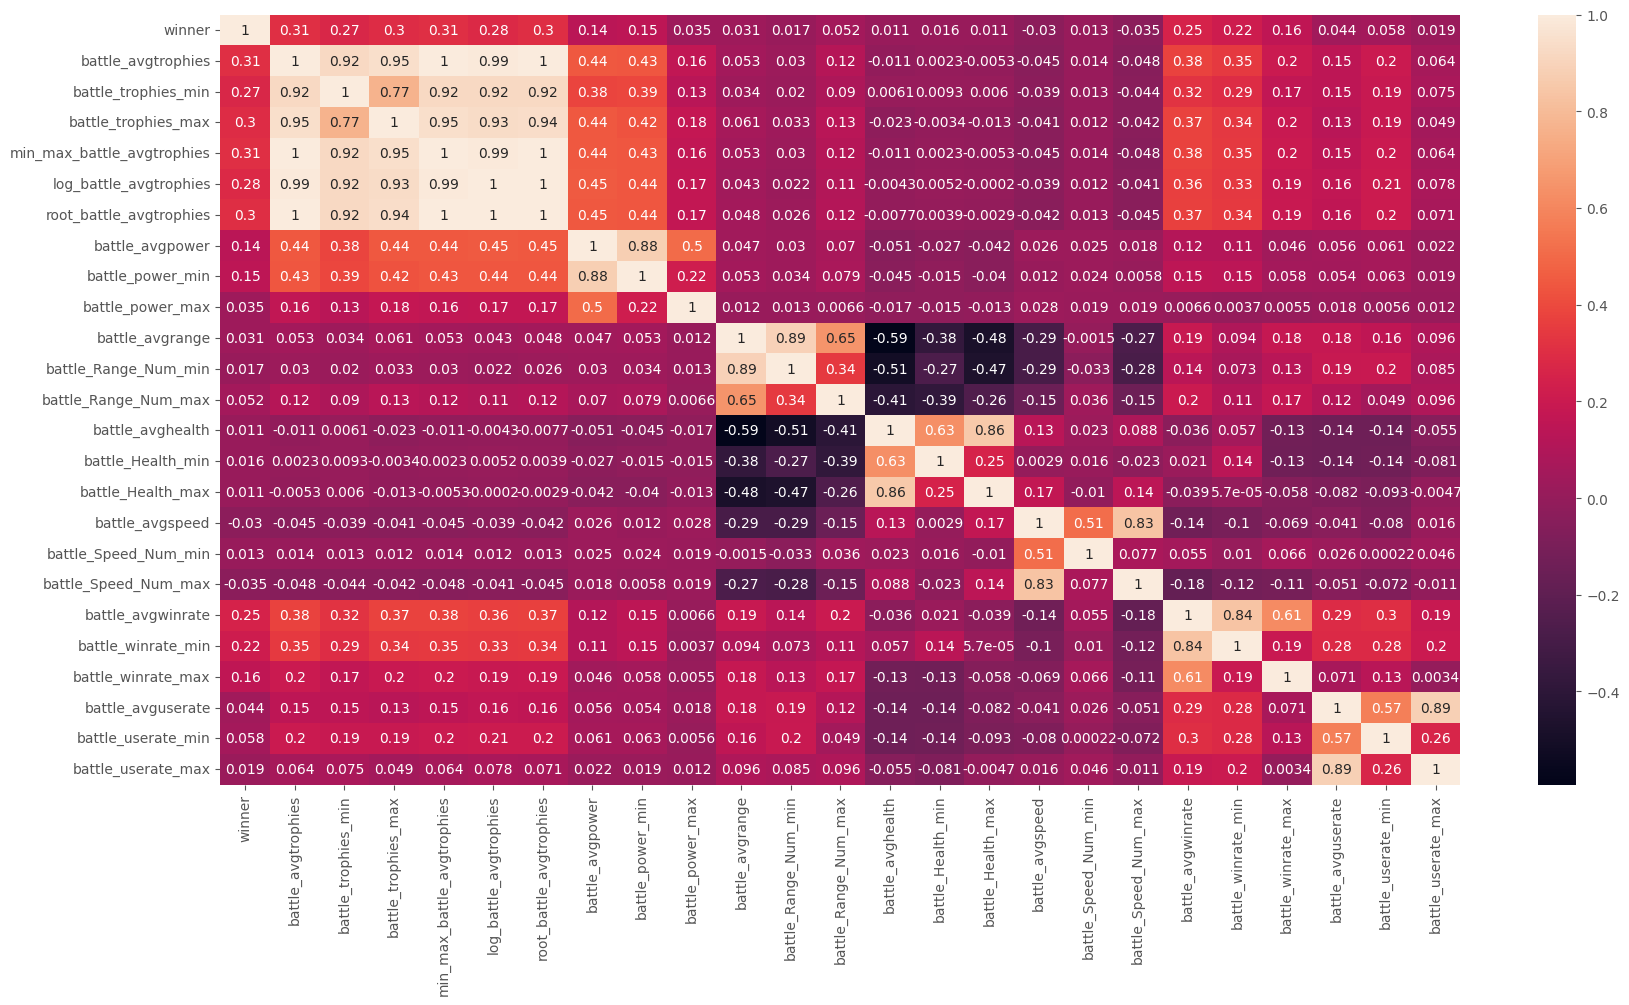

In [276]:
df = subset_battlelog('hotZone')

df['winner'] = df['winner'].replace({'yes': 1, 'no': 0}).astype(int)

def min_max_scaler_column(df, column_name):
    column = df[column_name]
    scaled_column = (column - column.min()) / (column.max() - column.min())
    return scaled_column

def binning(col, n_bins):
    bins = np.linspace(col.min(), col.max(), n_bins+1)
    labels = [i for i in range(n_bins)]
    return pd.cut(col, bins=bins, labels=labels, include_lowest=True)

df['min_max_battle_avgtrophies'] = min_max_scaler_column(df, 'battle_avgtrophies')
df['log_battle_avgtrophies'] = np.log(df['battle_avgtrophies'])
df['root_battle_avgtrophies'] = np.sqrt(df['battle_avgtrophies'])

fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df[[
	'winner'
	,'battle_avgtrophies'
	,'battle_trophies_min'
	,'battle_trophies_max'
	,'min_max_battle_avgtrophies'
	,'log_battle_avgtrophies'
	,'root_battle_avgtrophies'
	,'battle_avgpower'
	,'battle_power_min'
	,'battle_power_max'
	,'battle_avgrange'
	,'battle_Range_Num_min'
	,'battle_Range_Num_max'
	,'battle_avghealth'
	,'battle_Health_min'
	,'battle_Health_max'
	,'battle_avgspeed'
	,'battle_Speed_Num_min'
	,'battle_Speed_Num_max'
	,'battle_avgwinrate'
	,'battle_winrate_min'
	,'battle_winrate_max'
	,'battle_avguserate'
	,'battle_userate_min'
	,'battle_userate_max'
	]].corr(), annot=True, ax=ax)
plt.show()

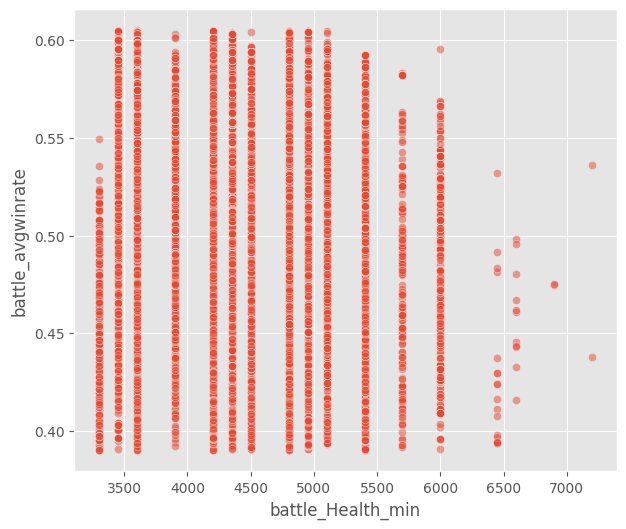

In [259]:
# scatterplot
fig, ax = plt.subplots(figsize=(7,6))
sns.scatterplot(data=df, y='battle_avgwinrate', x='battle_Health_min', ax=ax, alpha=0.5)
plt.show()

In [45]:
# cambiar working directory
print(os.getcwd())
os.chdir('machine_learning')
print(os.getcwd())

c:\Users\alniquia\OneDrive - Telefonica\Documents\Projects\BrawlStars_Model
c:\Users\alniquia\OneDrive - Telefonica\Documents\Projects\BrawlStars_Model\machine_learning


In [ ]:
from pycaret.classification import *
import xgboost
import catboost
from sklearn.model_selection import train_test_split

In [30]:
# generar set de testing y training
seed=14683

train, test = train_test_split(gamemode, test_size = 0.5, random_state=seed, stratify=gamemode['winner_team'])

train.shape

(186403, 36)

In [31]:
# setup model
session_1 = setup(
	data = train,
	target = 'winner_team',
	fix_imbalance = True,
    feature_selection= True,
	remove_outliers=True,
	log_experiment = True,
    use_gpu=False)

,Description,Value
0,session_id,8019
1,Target,winner_team
2,Target Type,Binary
3,Label Encoded,"team1: 0, team2: 1"
4,Original Data,"(186403, 36)"
5,Missing Values,False
6,Numeric Features,17
7,Categorical Features,18
8,Ordinal Features,False
9,High Cardinality Features,False


In [32]:
#comparación de modelos
model = compare_models(include=['rf','gbc','lightgbm','ada','catboost','xgboost'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.6440,0.7095,0.6398,0.6437,0.6417,0.2880,0.2881,72.8710
lightgbm,Light Gradient Boosting Machine,0.6390,0.7043,0.6301,0.6399,0.6350,0.2780,0.2780,24.6400
xgboost,Extreme Gradient Boosting,0.6360,0.6993,0.6312,0.6357,0.6334,0.2719,0.2720,129.2650
rf,Random Forest Classifier,0.6353,0.6840,0.6269,0.6360,0.6314,0.2705,0.2706,71.4090
gbc,Gradient Boosting Classifier,0.6348,0.6985,0.6274,0.6352,0.6313,0.2696,0.2697,111.1720
ada,Ada Boost Classifier,0.6244,0.6853,0.6239,0.6229,0.6234,0.2488,0.2489,40.0630


In [33]:
#try model blender

# example:
# train a few models
# lr = create_model('lr')
# dt = create_model('dt')
# knn = create_model('knn')

# blend models
# blender = blend_models([lr, dt, knn])
# blender_tuned = tune_model(blender, optimize = 'F1')

In [34]:
# tunear el mejor modelo
model_tuned = tune_model(model, optimize = 'F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6398,0.7078,0.6411,0.6379,0.6395,0.2796,0.2796
1,0.6405,0.7036,0.6366,0.6401,0.6383,0.2810,0.2810
2,0.6394,0.7056,0.6314,0.6401,0.6357,0.2788,0.2788
3,0.6442,0.7095,0.6406,0.6437,0.6422,0.2885,0.2885
4,0.6394,0.7031,0.6382,0.6382,0.6382,0.2788,0.2788
5,0.6432,0.7048,0.6426,0.6417,0.6422,0.2864,0.2864
6,0.6453,0.7078,0.6465,0.6433,0.6449,0.2906,0.2906
7,0.6431,0.7077,0.6370,0.6432,0.6401,0.2861,0.2861
8,0.6369,0.7025,0.6302,0.6371,0.6336,0.2737,0.2737


In [35]:
# compare hyperparameters
print(model)

print(model_tuned)

In [36]:
# interpret model
# interpret_model(model_tuned)

In [37]:
plot_model(model_tuned, plot='confusion_matrix', save=True)
plot_model(model_tuned, plot='feature', save=True)
plot_model(model_tuned, plot='calibration', save=True)

'Confusion Matrix.png'

In [42]:
# finalizar modelo
model_finalized = finalize_model(model_tuned)
predictions = predict_model(model_finalized, data = test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0,0.7105,0,0,0,0,0


In [ ]:
# create_app(model_finalized)

In [43]:
save_model(model_finalized, 'models/catboost_try2')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='winner_team', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_...
                 ('feature_select',
                  Advanced_Feature_Selection_Classic(ml_usecase='classification',
                                                     n_jobs=-1,
                                                     random_state=8019,
                    

In [44]:
predictions.to_csv('datasets/predictions/predictions_lc.csv')